# Drugi domaći zadatak iz Digitalne obrade slike

In [3]:
# ucitavanje potrebnih biblioteka
from skimage import io
import matplotlib.pyplot as plt
import skimage
from pylab import *
from skimage import color
import cv2
from scipy import ndimage
import numpy as np
import time

## 1. Poboljšanje kvaliteta polutonirane slike

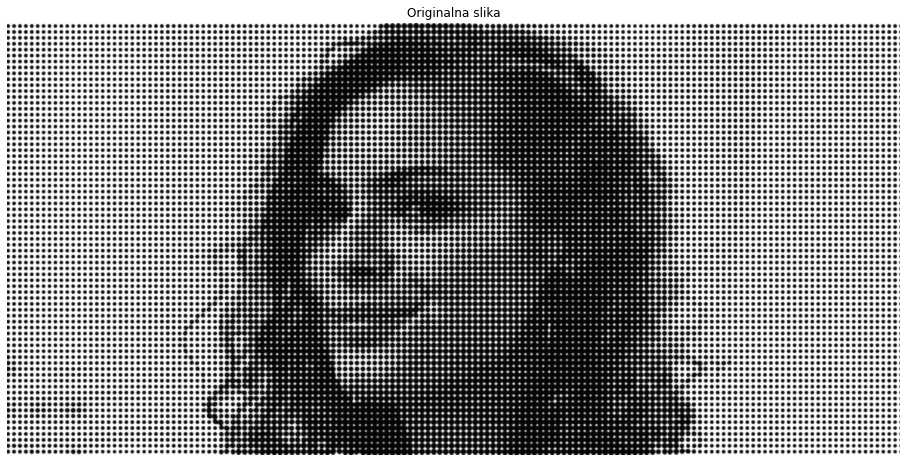

In [3]:
# ucitavanje slike
raw_1 = io.imread('../sekvence/girl_ht.tif')
raw_1 = skimage.img_as_float(raw_1)
# prikaz slike
plt.figure(figsize=(16,8))
plt.imshow(raw_1, 'gray') 
plt.title('Originalna slika')
plt.axis('off');

Iznad je prikazana učitana slika na kojoj se može opaziti prostoperiodična smetnja. Prikažimo sada spektar ove slike. 

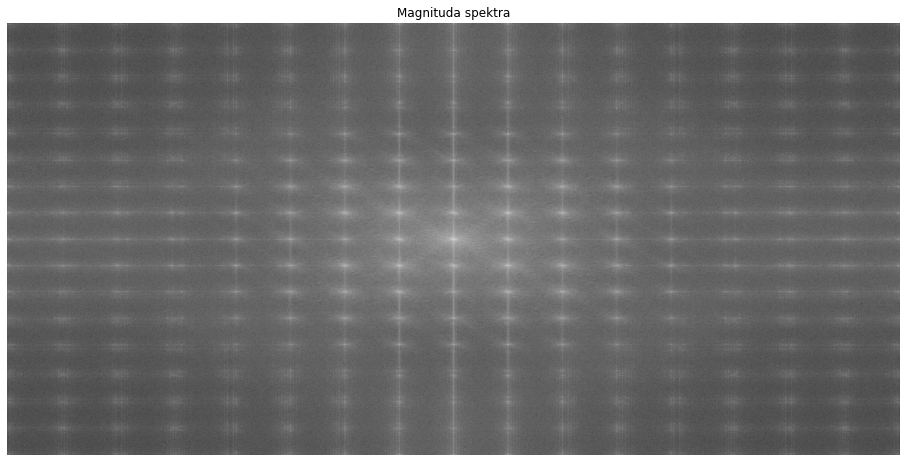

In [4]:
# Furijeova transformacija
raw_1_fft = np.fft.fft2(raw_1)
raw_1_fft_shift = np.fft.fftshift(raw_1_fft)

# Plotovanje magnitude spektra
raw_1_mag = 20*np.log(np.abs(raw_1_fft_shift))

plt.figure(figsize=(16,8))
plt.imshow(raw_1_mag, 'gray')
plt.title('Magnituda spektra')
plt.axis('off');

In [5]:
#predstava spektra u 3D
#x = list(range(0,raw_1_fft_shift.shape[1]))
#y = list(range(0,raw_1_fft_shift.shape[0]))

#X, Y = meshgrid(x, y)

#fig = plt.figure(figsize=(5,5), dpi=120)
#ax = plt.axes(projection='3d')
#ax.plot_surface(X, Y, abs(raw_1_fft_shift), cmap=cm.coolwarm); ax.set_title('Usrednjavanje 9x9');

Periodična smetnja se u spektru uočava kao ponavljanje svetle mrlje i po x i po y osi. Potrebno je propustiti samo centralni segment, ali kako se primenom niskopropusnog filtra dobije zamućena slika (pored periodične smetnje se unište i detalji slike), predloženo je korišćenje notch filtra kojim se redom uklanjaju svi svetli segmenti sem centralnog.

Prvo je potrebno implementirati funkciju za pravljenje odgovarajuće maske za filtriranje. Implementiran je notch propusnik/nepropusnik opsega sa različitim specifikacijama.

In [6]:
def cnotch(filt_type, notch, Ny, Nx, C, r, n=1):
    N_filters = len(C)
    
    filter_mask = zeros([Ny,Nx])
    
    if (Ny%2 == 0):
        y = np.arange(0,Ny) - Ny/2 + 0.5
    else:
        y = np.arange(0,Ny) - (Ny-1)/2
    
    if (Nx%2 == 0):
        x = np.arange(0,Nx) - Nx/2 + 0.5
    else:
        x = np.arange(0,Nx) - (Nx-1)/2

    X, Y = meshgrid(x, y)
    
    for i in range(0, N_filters):
        C_current = C[i]
        
        C_complement = zeros([2,1])
        C_complement[0] = -C_current[0]
        C_complement[1] = -C_current[1]
        
        if (Ny%2 == 0):
            y0 = y - C_current[0] + Ny/2 - 0.5
        else:
            y0 = y - C_current[0] + (Ny-1)/2
        
        if (Nx%2 == 0):
            x0 = x - C_current[1] + Nx/2 - 0.5
        else:
            x0 = x - C_current[1] + (Nx-1)/2
        
        X0, Y0 = meshgrid(x0, y0)
        
        D0 = np.sqrt(np.square(X0) + np.square(Y0))
    
        if (Ny%2 == 0):
            y0c = y - C_complement[0] - Ny/2 + 0.5
        else:
            y0c = y - C_complement[0] - (Ny-1)/2
        
        if (Nx%2 == 0):
            x0c = x - C_complement[1] - Nx/2 + 0.5
        else:
            x0c = x - C_complement[1] - (Nx-1)/2
        
        X0c, Y0c = meshgrid(x0c, y0c)
        
        D0c = np.sqrt(np.square(X0c) + np.square(Y0c))
    
        if filt_type == 'gaussian':
            filter_mask = filter_mask + \
                          exp(-np.square(D0)/(2*np.square(r))) + \
                          exp(-np.square(D0c)/(2*np.square(r)))
        elif filt_type == 'btw':
            filter_mask = filter_mask + \
                          1/(1+(D0/r)**(2*n)) + \
                          1/(1+(D0c/r)**(2*n))
        elif filt_type == 'ideal':
            filter_mask[(D0<=r)|(D0c<=r)] = 1
        else:
            print('Greška! Nije podržan tip filtra: ', filt_type)
            return
    
    if notch == 'pass':
        return filter_mask
    elif notch == 'reject':
        return 1 - filter_mask
    else:
        return

In [7]:
# dimenzije ucitane slike
[Ny, Nx] = shape(raw_1)

# pomeraj po x i y osi (eksperimentalno odredjeni posmatranjem spektra)
dist_x, dist_y = 150, 75
# broj pomeraja po x i y osi
x, y = (Nx//2)//dist_x + 1, (Ny//2)//dist_y + 1

In [8]:
# koordinate centara mrlja na spektru koje treba ukloniti
C = []
for i in range(0, y):
    for j in range(0, x):
        if(i != 0 or j != 0):
                C.append([Ny//2 + i*dist_y, Nx//2 + j*dist_x])
                C.append([Ny//2 + i*dist_y, Nx//2 - j*dist_x])

In [9]:
nr_filter_freq = cnotch('ideal', 'reject', Ny, Nx, C, 40) # definisanje maske (vrednost radijusa je eksperimentalno odredjena posmatranjem spektra)
# primena maske na spektar
img_fft_filt = raw_1_fft_shift*nr_filter_freq

In [10]:
# inverzna Furijeova transformacija
img_filt = real(ifft2(ifftshift(img_fft_filt)))
img_filt = np.clip(img_filt, 0, 1) # odsecanje vrednosti <0 i >1

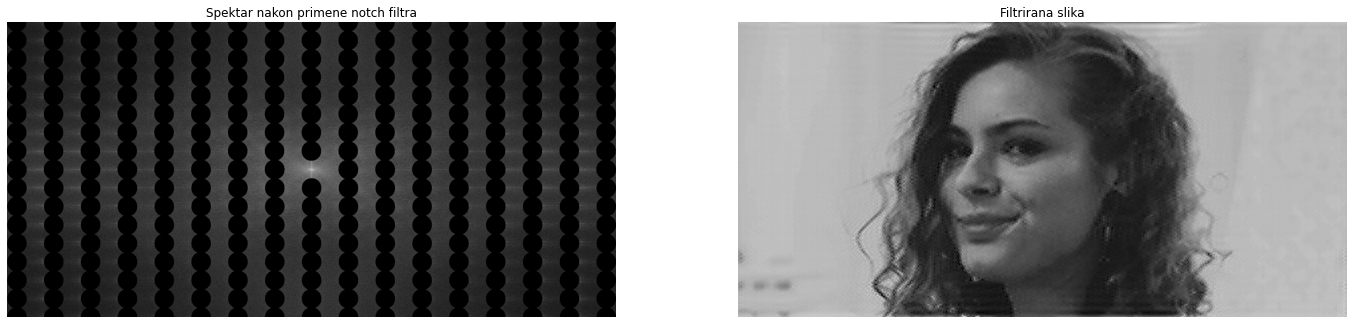

In [11]:
# prikaz spektra i filtrirane slike na jednom plotu
plt.figure(figsize=(24,12))
plt.subplot(121)
plt.imshow(log(1+abs(img_fft_filt)), 'gray')
plt.title('Spektar nakon primene notch filtra')
plt.axis('off')
plt.subplot(122)
plt.imshow(img_filt, 'gray')
plt.title('Filtrirana slika')
plt.axis('off');

Za specifikacije notch filtra korišćen je idealni filtar (koji se ispostavio kao najbolji, jer je Gausov i dalje propuštao segmente koje je bilo potrebno ukloniti) sa poluprečnikom 40 piksela (koji je eksperimentalno utvrđen). Možemo zapaziti da je dobijena slika značajno bolja i da se vidno otklonio periodični problem koji se javljao na početnoj slici. Međutim, i dalje su uočljive male nepravilnosti na licu koje je potrebno otkloniti dodatnim filtriranjem i kasnijim izoštravanjem.

Za dalju obradu je predloženo filtriranje medijan filtrom i pojačavanje ivica korišćenjem Laplasijana.

In [12]:
# primena medijan filtra
img_filt1 = img_filt*255
img_filt1 = ndimage.median_filter(img_filt, size=9)
img_filt1 = (img_filt1).clip(0,1)

In [13]:
# popravljanje oštrine slike
mask_1 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]) # definisanje maske
img_lap = ndimage.correlate(img_filt1, mask_1)            

img_sharp = ndimage.median_filter(img_filt, size=6) + img_lap
img_sharp = img_sharp.clip(0,1)

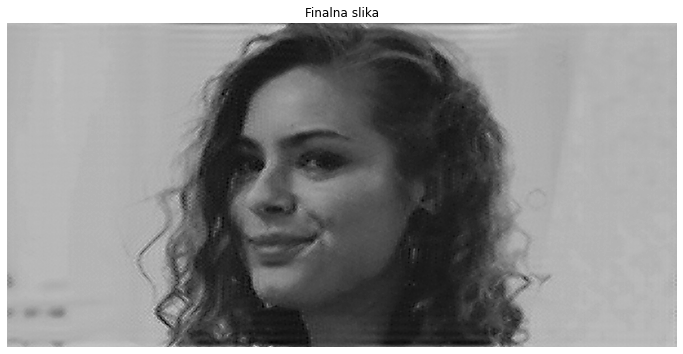

In [14]:
# prikaz rezultata
plt.figure(figsize=(12,8))
plt.imshow(img_sharp, 'gray')
plt.axis('off')
plt.title('Finalna slika')
plt.show()

Prikazana slika predstavlja finalni rezultat. Nejasnoće su i dalje blago uočljive, što se pripisuje velikom deformitetu početne slike i primeni idealnog filtra (grubo odsecanje).

## 2. Potiskivanje šuma adaptivnim filtriranjem

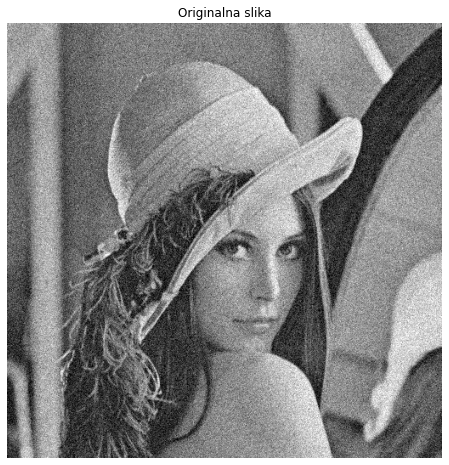

In [4]:
# ucitavanje slike
raw_2 = io.imread('../sekvence/lena_noise.tif')
raw_2 = skimage.img_as_float(raw_2)
# prikaz slike
plt.figure(figsize=(16,8))
plt.imshow(raw_2, 'gray') 
plt.title('Originalna slika')
plt.axis('off');

Na učitanoj slici, prisutan je šum sa nepoznatom varijansom koju je potrebno proceniti zarad kasnije implementacije filtriranja.     
Kao način procene, predloženo je prvobitno filtriranje niskopropusnim filtrom, kako bi se uklonio šum i dobila relativno konzistentna slika na lokalnim regionima. Na ovako dobijenoj slici, traži se segment sa minimalnom varijansom odbiraka, tačnije segment sa relativno konstantnom pozadinom. Na takvom segmentu, najtačnije se može proceniti varijansa šuma. Znači, varijasnu je potrebno odrediti na lokaciji koja se podudara datoj na originalnoj slici.

Implementiran je niskopropusni filtar kako bi se uradilo prvobitno filtriranje slike.

In [5]:
def lpfilter(filt_type, Ny, Nx, sigma, n=1):
    
    if (Ny%2 == 0):
        y = np.arange(0,Ny) - Ny/2 + 0.5
    else:
        y = np.arange(0,Ny) - (Ny-1)/2
    
    if (Nx%2 == 0):
        x = np.arange(0,Nx) - Nx/2 + 0.5
    else:
        x = np.arange(0,Nx) - (Nx-1)/2

    
    X, Y = meshgrid(x, y)
    
    D = np.sqrt(np.square(X) + np.square(Y))
    
    if filt_type == 'gaussian':
        filter_mask = exp(-np.square(D)/(2*np.square(sigma)))
    elif filt_type == 'btw':
        filter_mask = 1/(1+(D/sigma)**(2*n))
    elif filt_type == 'ideal':
        filter_mask = ones([Ny, Nx])
        filter_mask[D>sigma] = 0
    else:
        print('Greška! Nije podržan tip filtra: ', filt_type)
        return
    
    return filter_mask

In [6]:
# formiranje maske za primenu niskopropusnog filtra
lp = lpfilter('gaussian', raw_2.shape[1], raw_2.shape[0], 30)

In [7]:
# primena maske na spektar ulazne slike
raw_2_fft = np.fft.fft2(raw_2)
raw_2_fft_shift = np.fft.fftshift(raw_2_fft)
img_fft_filt = raw_2_fft_shift*lp

In [8]:
# inverzna Furijeova transformacija
img_filt = real(ifft2(ifftshift(img_fft_filt)))
img_filt = np.clip(img_filt, 0, 1) # odsecanje vrednosti <0 i >1

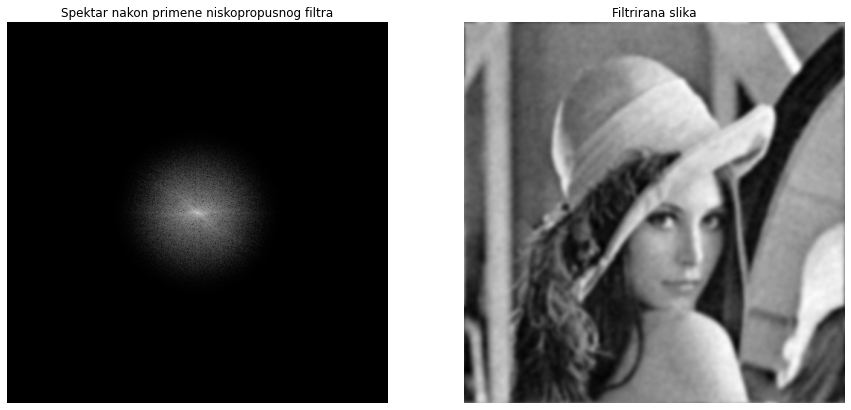

In [9]:
# prikaz spektra i filtrirane slike na jednom plotu
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(log(1+abs(img_fft_filt)), 'gray')
plt.title('Spektar nakon primene niskopropusnog filtra')
plt.axis('off')
plt.subplot(122)
plt.imshow(img_filt, 'gray')
plt.title('Filtrirana slika')
plt.axis('off');

Procena varijanse šuma slike 

In [10]:
num_of_segments = 15 # broj segmenata po dimenziji na koje se deli slika -> ukupno = 15x15
segment_x = img_filt.shape[0]//num_of_segments # dimenzije segmenta po x osi
segment_y = img_filt.shape[1]//num_of_segments # dimenzije segmenta po y osi
variances = []  # lista varijansi za svaki segment

for i in range(0, num_of_segments):
    for j in range(0, num_of_segments):
        if(i != 0 or j != 0):
            variances.append(np.var(img_filt[i*segment_x:(i+1)*segment_x, j*segment_y:(j+1)*segment_y])) # racunanje varijanse za svaki segment

index = np.argmin(variances) # indeks segmenta sa najmanjom varijansom
i = index//10   # indeks segmenta po x osi
j = index%10    # indeks segmenta po y osi
noise_var = np.var(raw_2[i*segment_x:(i+1)*segment_x, j*segment_y:(j+1)*segment_y]) # varijansa najmanjeg segmenta

Prva metoda koju je potrebno implementirati je adaptivno lokalno usrednjavanje. Ono se koristi kao alternativa aritmetičkom usrednjavanju, jer želimo da zadržimo informacije o ivicama slike.
$$ w(x,y) = \begin{cases}
       \frac{\sigma_{n}^2}{\sigma_{S_{xy}}^2}, \ \ \ \frac{\sigma_{n}^2}{\sigma_{S_{xy}}^2} \leq 1\\
       1, \ \ \ \ \ \ \ \frac{\sigma_{n}^2}{\sigma_{S_{xy}}^2} > 1
     \end{cases}$$
$$\hat{f}(x,y) = g(x,y) - w(x,y)[g(x,y) - \mu_{S_{xy}}]$$
Funkcija $\hat{f}(x,y)$ predstavlja filtriranu (estimiranu) sliku, koja u blizini ivica zadržava informacije sa ulazne slike ($g(xy)$), a na konzistentnijim delovima uzima informacije dobijene aritmetičkim usrednjavanjem ($\mu$). Ovo je uspostavljeno pomoću težinske funkcije $w$ koja se kreira pomoću navedene formule. U regionima slike gde je varijansa ($\sigma_{S_{xy}}^2$ - varijansa dela slike) manja od varijanse šuma ($\sigma_{n}^2$) nema detalja i $w = 1$. U obrnutnom slučaju $w$ treba biti manje (0-1) u zavisnosti od vrenosti varijansi.

In [110]:
def adaptivno_usrednjavanje(k = 7, noise_variance = noise_var):                             
    # k - velicina prozora za lokalno usrednjavanje
    filt_avg = ones([k,k])/(k**2)       # filter za lokalno usrednjavanje

    img_local_avg = ndimage.correlate(raw_2, filt_avg)          
    img_sqr_local_avg = ndimage.correlate(raw_2**2, filt_avg)   

    img_local_var = img_sqr_local_avg - img_local_avg**2    # lokalna varijansa 
    # (var = E((x-xsr)^2) = E(x^2) - 2*xsr*E(x) + xsr^2 = E(x^2) - xsr^2)

    weight = noise_variance/img_local_var    # racunanje tezine
    weight[weight > 1] = 1                   # maksimalna vrednost tezine je 1

    img_est = raw_2 - weight*(raw_2-img_local_avg)  # estimirana slika po formuli
    return img_est

In [12]:
slike = [] # lista za cuvanje slika za razlicite velicine prozora
for i in range(4, 20, 3):
    slike.append(adaptivno_usrednjavanje(i))

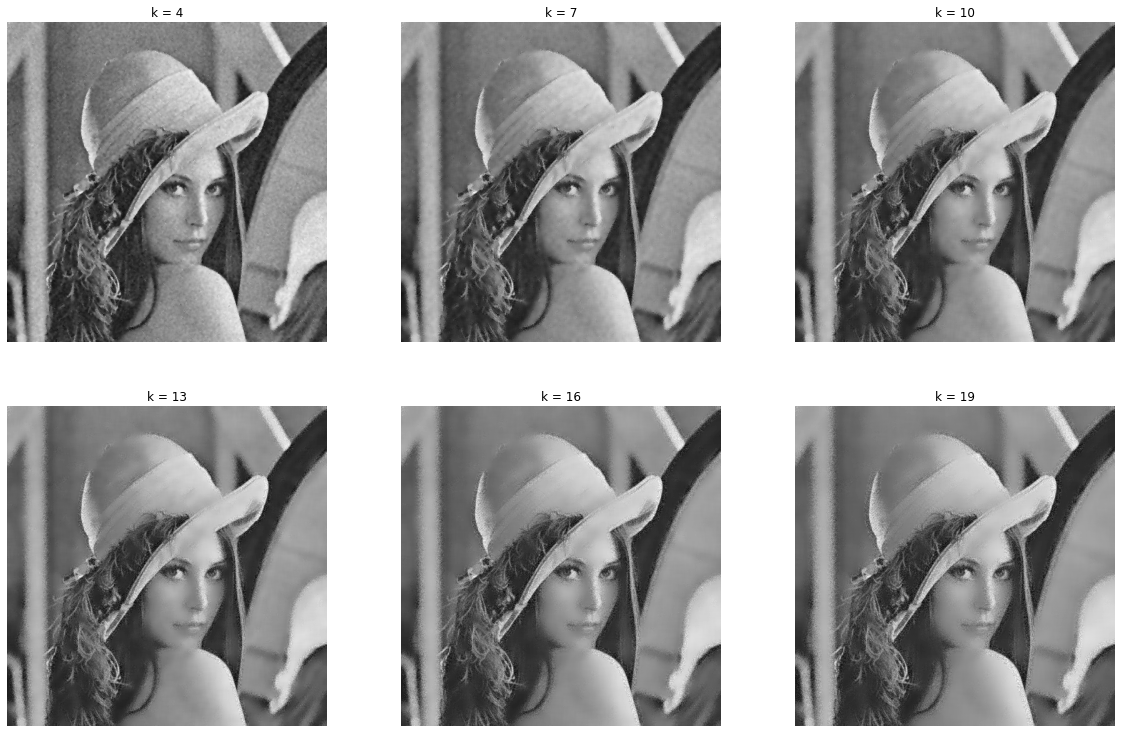

In [13]:
# prikaz svih slika
plt.figure(figsize=(20,20))
for i in range(0, len(slike)):
    plt.subplot(3,3,i+1)
    plt.imshow(slike[i], 'gray')
    plt.title('k = ' + str(3*i+4))
    plt.axis('off');

Veličina maske, k=7, se ispostavlja kao optimalni izbor parametara zato što se uočava dobro potiskivanje šuma ali i dovoljno dobro očuvanje informacije na slici i njene oštrine.

Druga metoda koju je potrebno implementirati je Bilateralni filtar. On uvodi težine za rastojanje, kao i težinu po intenzitetima.    
$$\hat{f}(x,y) = \frac{1}{k(x,y)}\sum{g(s,t)w(s,t)}$$
$w(s,t)$ je maska koja odgovara uticaju oba parametra. Ona zavisi od $\sigma_s$ i $\sigma_r$, koji su redom std za prostorni uticaj okolnih odbiraka i std za uticaj sličnosti boja.


Radi preglednosti ostavljen je prikaz zavisnosti izgleda filtrirane slike od jednog parametara (dok su ostala dva bila fiksirana).

In [44]:
d = 15              # velicina prozora
sigmaColor = 0.1    # parametar za boju
sigmaSpace = 20     # parametar za prostor

params_d = [5, 10, 15, 20]
params_sigmaColor = [0.05, 0.1, 0.15, 0.2]
params_sigmaSpace = [5, 10, 20, 30]

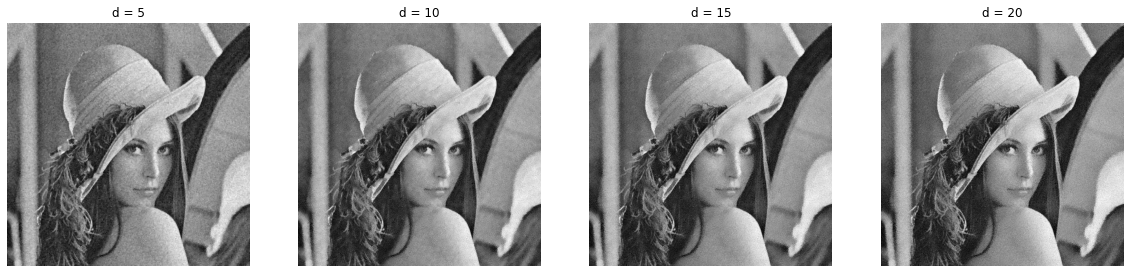

In [45]:
# uticaj parametra d
plt.figure(figsize=(20,15))
for i in range(0, len(params_d)):
    bilateral = cv2.bilateralFilter(image, params_d[i], sigmaColor, sigmaSpace)
    plt.subplot(1,4,i+1)
    plt.imshow(bilateral, 'gray')
    plt.title('d = ' + str(params_d[i]))
    plt.axis('off');

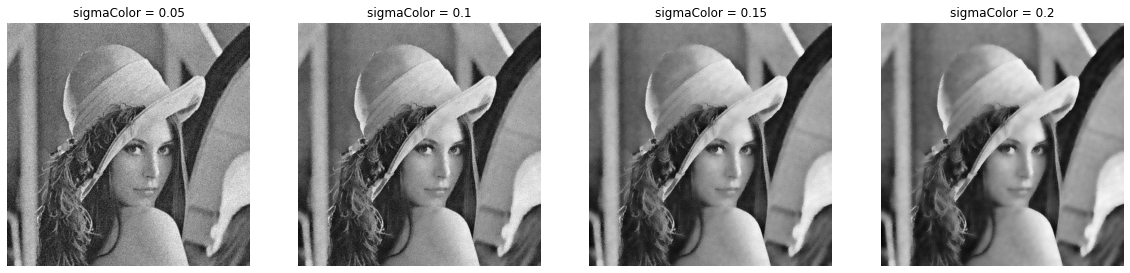

In [46]:
# uticaj parametra sigmaColor
plt.figure(figsize=(20,15))
for i in range(0, len(params_sigmaColor)):
    bilateral = cv2.bilateralFilter(image, d, params_sigmaColor[i], sigmaSpace)
    plt.subplot(1,4,i+1)
    plt.imshow(bilateral, 'gray')
    plt.title('sigmaColor = ' + str(params_sigmaColor[i]))
    plt.axis('off');

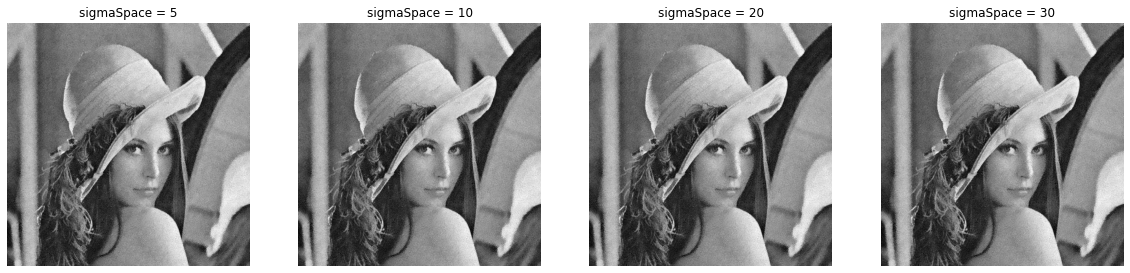

In [47]:
# uticaj parametra sigmaSpace
plt.figure(figsize=(20,15))
for i in range(0, len(params_sigmaSpace)):
    bilateral = cv2.bilateralFilter(image, d, sigmaColor, params_sigmaSpace[i])
    plt.subplot(1,4,i+1)
    plt.imshow(bilateral, 'gray')
    plt.title('sigmaSpace = ' + str(params_sigmaSpace[i]))
    plt.axis('off');

Finalni izbor parametara usledio je nakon analize njihovih uticaja kako pojedinačno, tako i grupno.

In [103]:
image = raw_2.astype(np.float32)   # pocetna slika

d = 15              # velicina prozora
sigmaColor = 0.1    # parametar za boju
sigmaSpace = 20     # parametar za prostor

img_bilat = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace) # primena bilateralnog filtra

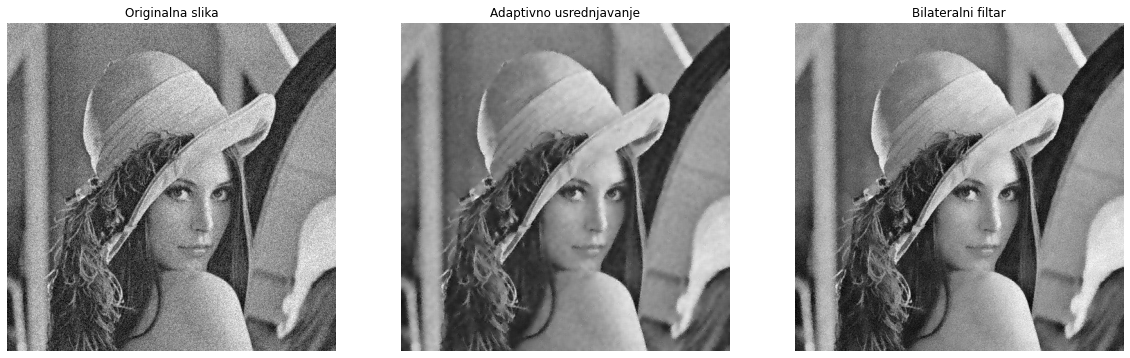

In [116]:
# prikaz rezultata
plt.figure(figsize=(20,8))
plt.subplot(131)
plt.imshow(raw_2, 'gray')
plt.title('Originalna slika')
plt.axis('off')
plt.subplot(132)
plt.imshow(adaptivno_usrednjavanje(k=7), 'gray')
plt.title('Adaptivno usrednjavanje')
plt.axis('off')
plt.subplot(133)
plt.imshow(img_bilat, 'gray')
plt.title('Bilateralni filtar')
plt.axis('off');

Slika dobijena Bilateralnim filtriranjem bolje ubija šum koji se vidno uočavao na slici na početku zadatka u odnosu na adaptivno usrednjavanje. Detalji i ivice slike kod adaptivnog usrednjavanja postaju zamućeniji, dok Bilateralni to bolje kontroliše zbog posmatranja razlike između vrednosti piksela (boje) koja takođe utiče na filtriranje.

## 3. Obilazak Beograda

In [111]:
# ucitavanje slika
raw_3 = io.imread('../sekvence/kernel.tif')
raw_3 = skimage.img_as_float(raw_3)
size_3 = raw_3.shape

raw_4 = io.imread('../sekvence/etf_blur.tif')
raw_4 = skimage.img_as_float(raw_4)
size_4 = raw_4.shape

In [112]:
# prosirivanje slike (kernela), tako da se dimenzije poklapaju sa dimenzijama zamućene slike
raw_3 = np.pad(raw_3, ((0, raw_4.shape[0]-raw_3.shape[0]), (0, raw_4.shape[1]-raw_3.shape[1])))

In [113]:
# frekvencijski domen ulazne slike i kernela
raw_4_fft = np.fft.fft2(raw_4)
raw_4_fft = np.fft.fftshift(raw_4_fft)
raw_3_fft = np.fft.fft2(raw_3)
raw_3_fft = np.fft.fftshift(raw_3_fft)

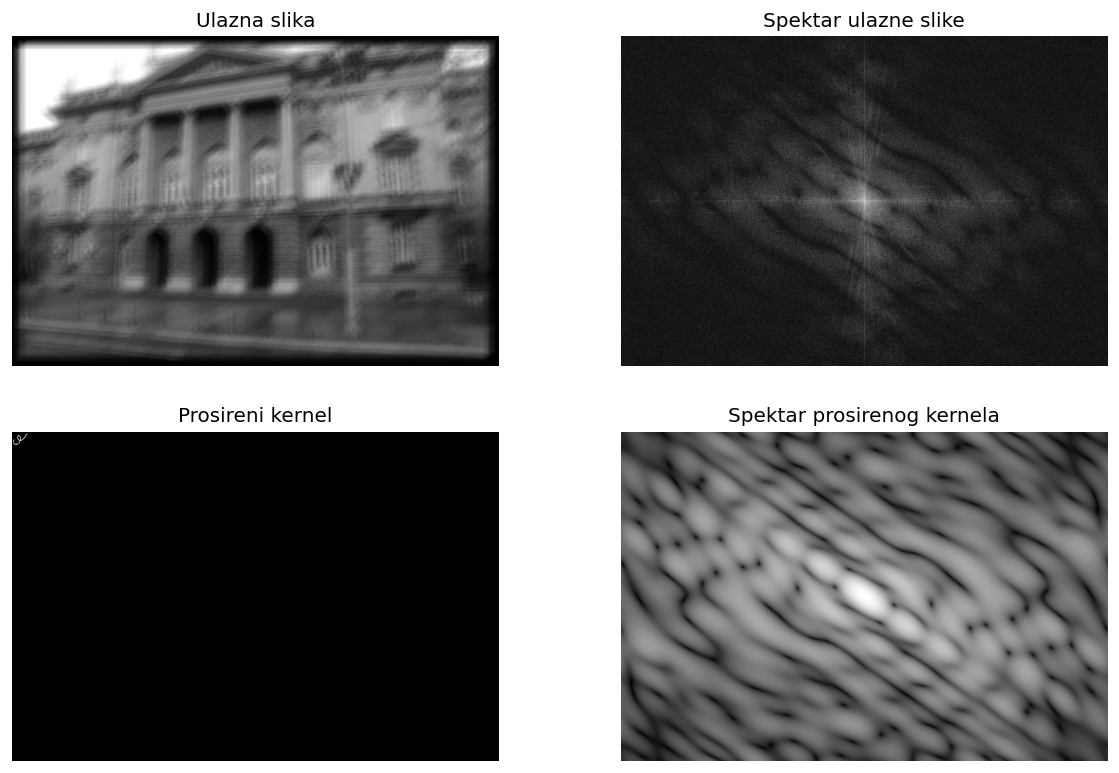

In [115]:
# prikaz slika
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), dpi=120)
ax = axes.ravel()

ax[0].imshow(raw_4, cmap='gray'); ax[0].set_axis_off(); ax[0].set_title('Ulazna slika')
ax[1].imshow(log(1+abs(raw_4_fft)), cmap='gray'); ax[1].set_axis_off(); ax[1].set_title('Spektar ulazne slike')
ax[2].imshow(raw_3, cmap='gray'); ax[3].set_axis_off(); ax[3].set_title('Spektar prosirenog kernela');
ax[3].imshow(log(1+abs(raw_3_fft)), cmap='gray'); ax[2].set_axis_off(); ax[2].set_title('Prosireni kernel');

Na gore prikazanom grafiku mogu se videti zamućena ulazna slika, njen spektar, pokret koji je napravljen tokom fotografisanja (kernel koji je proširen na dimenzije ulazne slike) i njegov spektar. Potrebno je otkloniti degradaciju usled pokreta i kao pristup tome je predloženo filtriranje Vinerovim filtrom.

$$\hat{F}(u,v) = \frac{|H(u,v)|^2}{|H(u,v)|^2 + k}\cdot \frac{G(u,v)}{H(u,v)}$$

Parametar $k$ predstavlja jačinu filtriranja i njime se pretpostavlja odnos spektra snage šuma i nedegradirane slike. Što je ona veća, to je efekat filtriranja manji, a što je $k$ manje svodimo se na inverzno filtriranje gde dobro otklanjamo blur, ali postoji mogućnost da se jako istakne šum.

In [134]:
k = 5  # jacina filtriranja
W = (abs(raw_3_fft)**2)/(abs(raw_3_fft)**2 + k)

img_fft_est = (raw_4_fft/raw_3_fft)*W

img_est = real(ifft2(ifftshift(img_fft_est)))   # estimirana slika
img_est = np.clip(img_est, 0, 1)                # odsecanje vrednosti <0 i >1
img_est = img_est[0:size_4[0]-size_3[0], 0:size_4[1]-size_3[1]] # odsecanje ivica

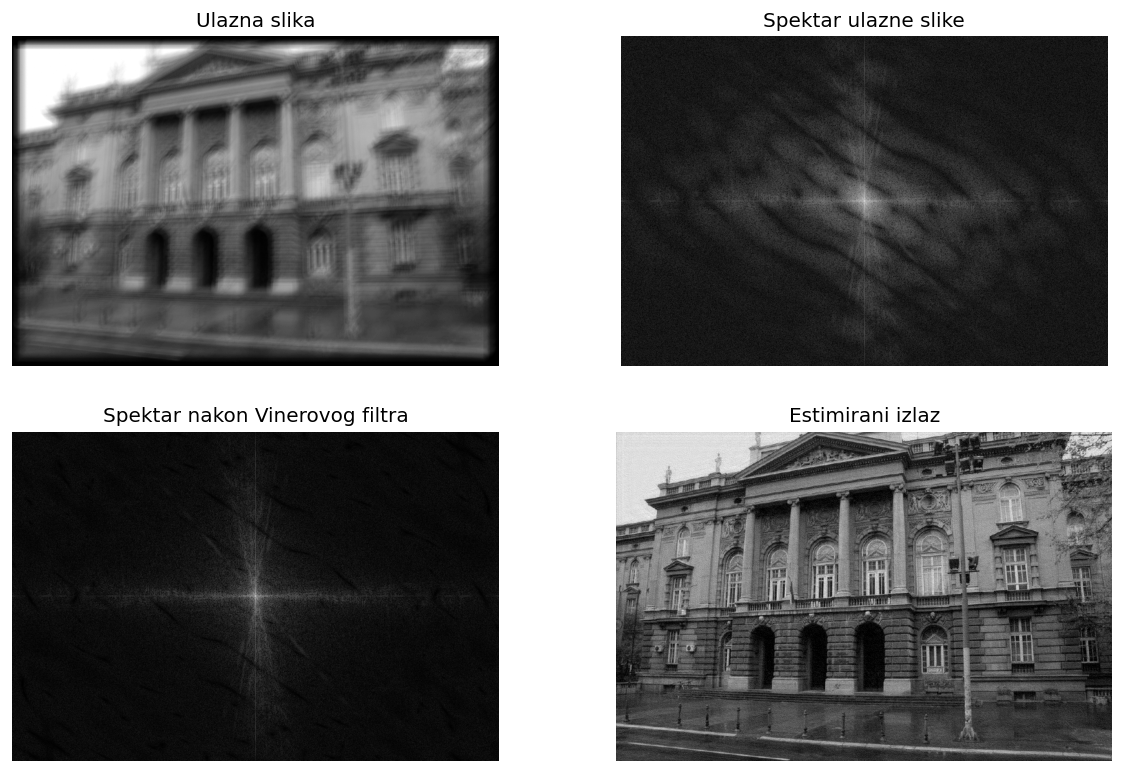

In [135]:
# prikaz rezultata
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), dpi=120)
ax = axes.ravel()

ax[0].imshow(raw_4, cmap='gray'); ax[0].set_axis_off(); ax[0].set_title('Ulazna slika')
ax[1].imshow(log(1+abs(raw_4_fft)), cmap='gray'); ax[1].set_axis_off(); ax[1].set_title('Spektar ulazne slike')
ax[2].imshow(log(1+abs(img_fft_est)), cmap='gray'); ax[2].set_axis_off(); ax[2].set_title('Spektar nakon Vinerovog filtra')
ax[3].imshow(img_est, cmap='gray'); ax[3].set_axis_off(); ax[3].set_title('Estimirani izlaz');

Na slici iznad prikazana je estimirana slika nakon uklanjanja degradacije. Posmatranjem spektara slika, isto se može opaziti nestanak komponenti prouzrokovanih zamićenjem.      

Ispod je prikazan način izbora parametra $k=5$. Za $k = 0.0000001$ uočljiv je blagi šum, a za velike vrednosti ($k = 40$) uočava se zamućenje (slabiji uticaj filtra). Ovakvo ponašanje potvrđuje prethodno opisano očekivanje.

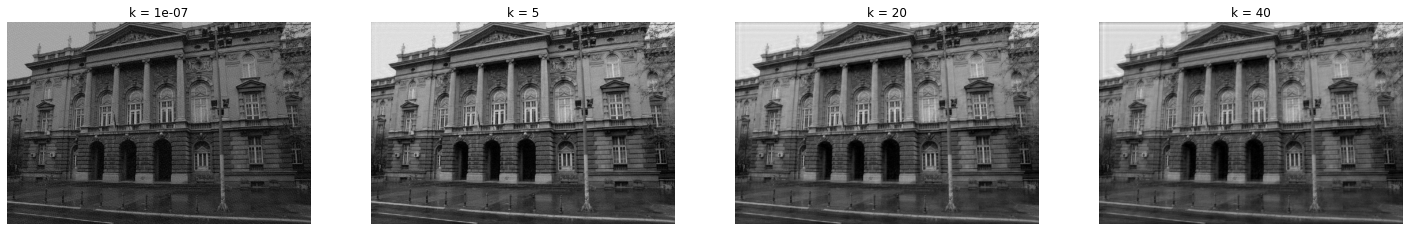

In [133]:
k = [0.0000001, 5, 20, 40] # jacina filtriranja
plt.figure(figsize=(25,15))
for k_ in k:
    W = (abs(raw_3_fft)**2)/(abs(raw_3_fft)**2 + k_)
    img_fft_est = (raw_4_fft/raw_3_fft)*W
    img_est = real(ifft2(ifftshift(img_fft_est)))   # estimirana slika
    img_est = np.clip(img_est, 0, 1)                # odsecanje vrednosti <0 i >1
    img_est = img_est[0:size_4[0]-size_3[0], 0:size_4[1]-size_3[1]] # odsecanje ivica
    plt.subplot(1,4,k.index(k_)+1)
    plt.imshow(img_est, 'gray')
    plt.title('k = ' + str(k_))
    plt.axis('off');

## 4. Poređenje brzine filtriranja 

$$G(x,y) = \frac{1}{2\pi\sigma^2}\cdot e^{-\frac{x^2+y^2}{2\sigma^2}} $$
Maska Gausovog filtra formira se u zavisnosti od radijusa filtra i standardne devijacije. Kako važe karakterstike simetričnosti i separabilnosti (koja je uslovljena prethodnom), Moguće je podeliti masku:
$$G1(x,y) = \frac{1}{\sqrt{2\pi}\sigma}\cdot e^{-\frac{x^2}{2\sigma^2}} \ \ \ \ \text{i} \ \ \ \ G2(x,y) = \frac{1}{\sqrt{2\pi}\sigma}\cdot e^{-\frac{y^2}{2\sigma^2}}$$
Filtriranje se zatim može vršiti primenom maske 1 na region, a zatim maske 2, što rezultuje manjim brojem operacija, a samim tim efikasnijim i bržim kodom.

Filtriranje slike u prostornom domenu bez korišćenja karakteristike separabilnosti

In [136]:
def filter_gauss(input_image, filter_radius, gauss_std):
    size = filter_radius*2 + 1      # velicina maske se formira tako da se doda radius sa svake strane i centralni piksel (+1) predstavlja centar
    mask = np.ones((size, size))    # inicijalizacija maske  

    # pravljenje maske za gausov filtar  
    for i in range(0, size):
        for j in range(0, size):
            mask[i][j] = np.exp(-((i-filter_radius)**2 + (j-filter_radius)**2)/(2*gauss_std**2))/(2*np.pi*gauss_std**2)

    # ponavljanje ivicnih piksela za prosirenje slike
    padded_image = np.pad(input_image, filter_radius, 'edge')

    # primena maske na sliku
    for i in range(0, input_image.shape[0]):
        for j in range(0, input_image.shape[1]):
            padded_image[i+filter_radius][j+filter_radius] = np.multiply(padded_image[i:i+size,j:j+size], mask).sum()/(mask.sum())

    return padded_image[filter_radius:input_image.shape[0]+filter_radius, filter_radius:input_image.shape[1]+filter_radius]

Filtriranje slike u prostornom domenu sa korišćenjem karakteristike separabilnosti

In [137]:
def filter_gauss_separ(input_image, filter_radius, gauss_std):
    size = filter_radius*2+1  
    mask_x = np.ones((1,size))  # inicijalizacija maske po x osi
    mask_y = np.ones((size,1))  # inicijalizacija maske po y osi

    # pravljenje maski za gausov filtar  
    for i in range(0, size):
        mask_x[0][i] = mask_y[i][0] = (1/(sqrt(2*np.pi)*gauss_std))*np.exp(-((i-filter_radius)**2)/(2*gauss_std**2))

    # ponavljanje ivicnih piksela za prosirenje slike
    padded_image = np.pad(input_image, filter_radius, 'edge')

    # primena maski na sliku
    for i in range(0, input_image.shape[0]):
        for j in range(0, input_image.shape[1]):
            mul_with_x = np.multiply(mask_x, padded_image[i:i+size,j:j+size]).sum(axis=1)[np.newaxis].T/np.sum(mask_x)
            mul_with_y = np.multiply(mask_y, mul_with_x).sum()/np.sum(mask_y)
            padded_image[i+filter_radius][j+filter_radius] = mul_with_y
     
    return padded_image[filter_radius:input_image.shape[0]+filter_radius, filter_radius:input_image.shape[1]+filter_radius]

Filtriranje slike se takođe može izvršiti u frekvencijskom domenu

In [138]:
def filter_gauss_freq(input_image, filter_radius, gauss_std):
    size = filter_radius*2 + 1
    mask = np.ones((size, size))

    # pravljenje maske za gausov filtar  
    for i in range(0, size):
        for j in range(0, size):
            mask[i][j] = np.exp(-((i-filter_radius)**2 + (j-filter_radius)**2)/(2*gauss_std**2))/(2*np.pi*gauss_std**2)

    # ponavljanje ivicnih piksela za prosirenje slike
    padded_image = np.pad(input_image, filter_radius, 'edge')
    mask = np.pad(mask, ((0, padded_image.shape[0]-mask.shape[0]), (0, padded_image.shape[1]-mask.shape[1])), 'constant')

    # prebacivanje slike i kernela u frekvencijski domen
    padded_image_fft = fft2(padded_image)
    mask_fft = abs(fft2(mask))
    padded_image_fft /= np.max(padded_image_fft)

    # primena filtra u frekvencijskom domenu
    padded_filt_fft = padded_image_fft * mask_fft

    # prebacivanje slike u prostorni domen
    padded_filt = np.abs(ifft2(padded_filt_fft))

    return padded_filt[filter_radius:input_image.shape[0]+filter_radius, filter_radius:input_image.shape[1]+filter_radius]

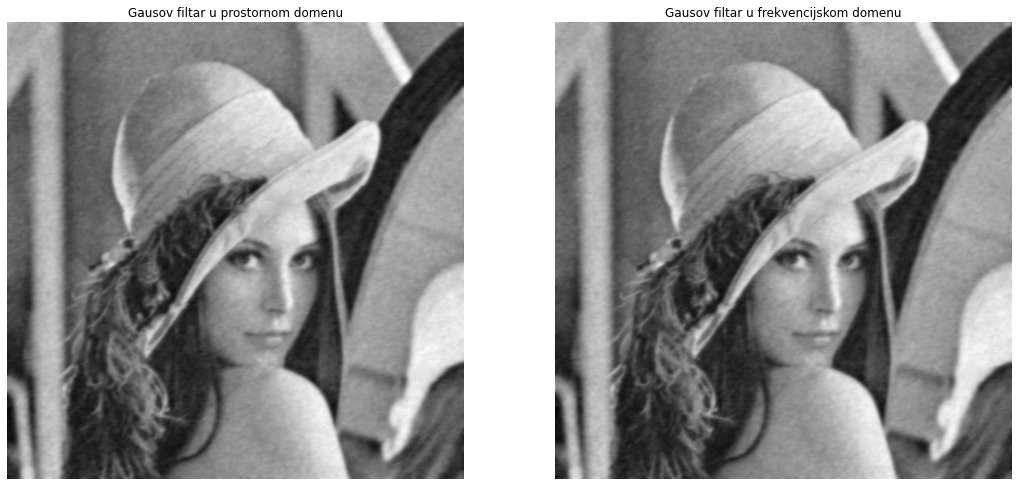

In [142]:
rad = 5 # radijus maske
img1 = filter_gauss_separ(raw_2, rad, 1/3*rad)
img2 = filter_gauss(raw_2, rad, 1/3*rad)

# prikaz rezultata
plt.figure(figsize=(18,16))
plt.subplot(121)
plt.imshow(img1, 'gray')
plt.title('Gausov filtar u prostornom domenu')
plt.axis('off')
plt.subplot(122)
plt.imshow(img2, 'gray')
plt.title('Gausov filtar u frekvencijskom domenu')
plt.axis('off');

Vrednosi piksela slika dobijenih filtriranjem u vremenskom i u frekvencijskom domenu su iste do na 15-tu decimalu. Ova dva procesa su ekvivalentna, međutim, uporedimo im vremenske performanse.

In [154]:
rads = np.linspace(1, 50, 49)       # radijusi maski za koje ce se racunati vreme izvrsavanja
vreme_1 = []                        # vreme izvrsavanja filtriranja u prostornom domenu
vreme_2 = []                        # vreme izvrsavanja filtriranja u frekvencijskom domenu
for rad in rads:
    rad = int(rad)
    start_vreme = time.time()                           # pocetak merenja vremena
    figure_1 = filter_gauss_separ(raw_2, rad, 1/3*rad)  # primena filtra u prostornom domenu
    end_vreme = time.time()                             # kraj merenja vremena
    vreme_1.append(end_vreme-start_vreme)               # dodavanje vremena izvrsavanja u listu
    
    start_time = time.time()                            # pocetak merenja vremena       
    figure_2 = filter_gauss_freq(raw_2, rad, 1/3*rad)   # primena filtra u frekvencijskom domenu
    end_time = time.time()                              # kraj merenja vremena
    vreme_2.append(end_time-start_time)                 # dodavanje vremena izvrsavanja u listu

Poređenje vremena izvršavanja filtriranja u prostornom i frekvencijskom domenu

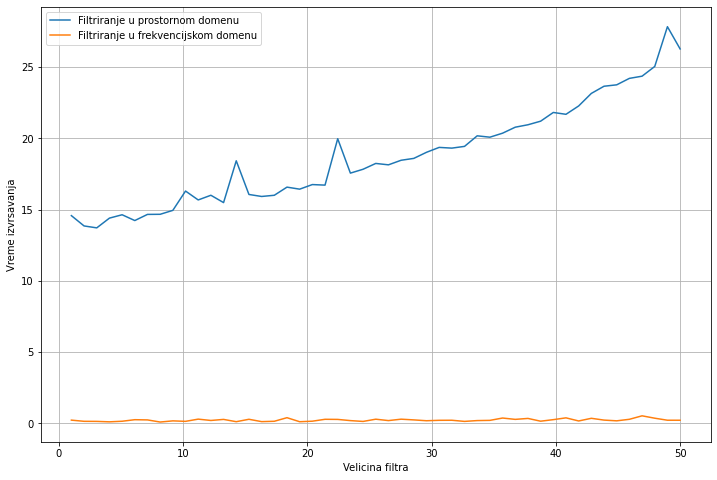

In [156]:
# prikaz rezultata
plt.figure(figsize=(12,8))
plt.plot(rads, vreme_1, label='Filtriranje u prostornom domenu')
plt.plot(rads, vreme_2, label='Filtriranje u frekvencijskom domenu')
plt.xlabel('Velicina filtra')
plt.ylabel('Vreme izvrsavanja')
plt.grid()
plt.legend()
plt.show()

Filtriranje u frekvencijskom domenu radi brže, a to je i očekivano jer se operacija konvolucije svodi na prosto množenje. Manji broj operacija => brzina.    
Filtriranje u prostornom domenu nekada može biti korisnije zato što imamo uvid u direktne pozicije i vrednosti piksela, a samim tim lepo možemo izdvojiti prelaze i ivice.